In [8]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import json
from shapely.geometry import Polygon, LineString, Point
import matplotlib.patches as patches

In [9]:
# Abre el archivo GeoTIFF
dataset = rasterio.open('..\\data\\Zona\\of5mtif1678296896753.tif')

# Imprime información sobre el archivo
print(f'Número de bandas: {dataset.count}')
print(f'Tamaño del archivo: {dataset.width}x{dataset.height}')
print(f'Sistema de coordenadas: {dataset.crs}')

Número de bandas: 3
Tamaño del archivo: 13734x13638
Sistema de coordenadas: EPSG:25831


In [10]:
def image_to_window(coordenadas_image, coordenadas_window, transform, shape):
    xmin, ymin, xmax, ymax = coordenadas_image
    xmin_window, ymin_window = coordenadas_window
    len_y, len_x, len_z = shape

    # Ajusta las posiciones de los rectángulos a la ventana
    xmin, ymin, xmax, ymax = xmin - xmin_window, ymin - ymin_window, xmax - xmin_window, ymax - ymin_window
    
    # Escala las posiciones a la resolución de la imagen
    xmin, ymin, xmax, ymax = xmin / transform.a, ymin / transform.a, xmax / transform.a, ymax / transform.a

    # Invierte las coordenadas en el eje y
    ymin, ymax = len_y - ymax, len_y - ymin

    return int(xmin), int(ymin), int(xmax), int(ymax)

def window_to_image(coordenadas_image, coordenadas_window, transform, shape):
    xmin, ymin, xmax, ymax = coordenadas_image
    xmin_window, ymin_window = coordenadas_window
    len_y, len_x, len_z = shape

    # Invierte las coordenadas en el eje y
    ymin, ymax = len_y - ymax, len_y - ymin

    # Escala las posiciones a la resolución de la imagen
    xmin, ymin, xmax, ymax = xmin * transform.a, ymin * transform.a, xmax * transform.a, ymax * transform.a

    # Ajusta las posiciones de los rectángulos a la ventana
    xmin, ymin, xmax, ymax = xmin - xmin_window, ymin - ymin_window, xmax - xmin_window, ymax - ymin_window
    
    return int(xmin), int(ymin), int(xmax), int(ymax)

def xyxy_to_cxcywh(coordenadas):
    xmin, ymin, xmax, ymax = coordenadas
    x = (xmin + xmax) / 2
    y = (ymin + ymax) / 2
    w = xmax - xmin
    h = ymax - ymin
    return int(x), int(y), int(w), int(h)

def cxcywh_to_xyxy(coordenadas):
    x, y, w, h = coordenadas
    xmin = x - w / 2
    ymin = y - h / 2
    xmax = x + w / 2
    ymax = y + h / 2
    return int(xmin), int(ymin), int(xmax), int(ymax)

# Funcion que pasa xmin, ymin, xmax, ymax a x, y, w, h siendo x, y la esquina superior izquierda
def xyxy_to_xywh(coordenadas):
    xmin, ymin, xmax, ymax = coordenadas
    x = xmin
    y = ymin
    w = xmax - xmin
    h = ymax - ymin
    return int(x), int(y), int(w), int(h)

# Funcion que pasa x, y, w, h a xmin, ymin, xmax, ymax siendo x, y la esquina superior izquierda
def xywh_to_xyxy(coordenadas):
    x, y, w, h = coordenadas
    xmin = x
    ymin = y
    xmax = x + w
    ymax = y + h
    return int(xmin), int(ymin), int(xmax), int(ymax)

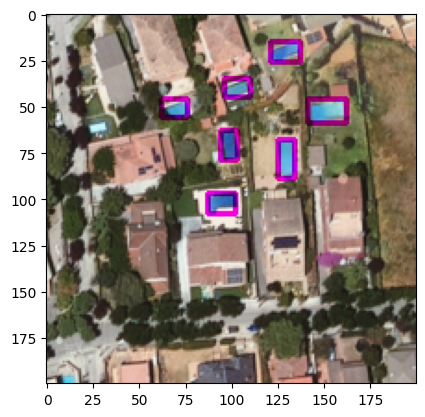

In [4]:
# Lee el archivo shapefile
regions = gpd.read_file('..\\data\\Zona\\clean\\bt5mv20sh0f286122hp1r060.shp')

xmin_window, ymin_window, xmax_window, ymax_window = 420660, 4590892, 420660+100, 4590892+100

# Recorta el GeoTIFF según las coordenadas de la window
window = rasterio.windows.from_bounds(xmin_window, ymin_window, xmax_window, ymax_window, dataset.transform)
clipped_data = dataset.read(window=window)
clipped_data = np.moveaxis(clipped_data, 0, -1)

area = Polygon([(xmin_window, ymin_window), (xmax_window, ymin_window), (xmax_window, ymax_window), (xmin_window, ymax_window)])

for region in regions[regions.geometry.covered_by(area)].geometry:
    
    xmin, ymin, xmax, ymax = region.bounds

    xmin, ymin, xmax, ymax = image_to_window((xmin, ymin, xmax, ymax), (xmin_window, ymin_window), dataset.transform, clipped_data.shape)

    # Dibuja los rectángulos
    cv2.rectangle(clipped_data[:, :, 1], (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2)

# Visualiza la ventana con los rectángulos
plt.imshow(clipped_data)
plt.show()

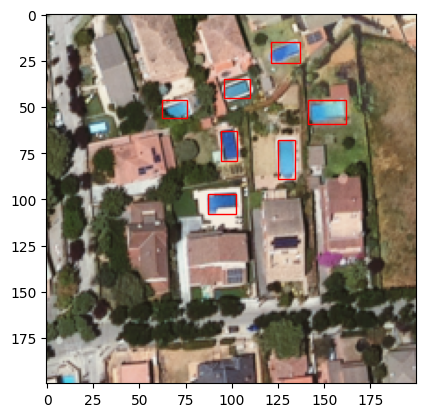

In [17]:
# Lee el archivo shapefile
regions = gpd.read_file('..\\data\\Zona\\clean\\bt5mv20sh0f286122hp1r060.shp')

xmin_window, ymin_window, xmax_window, ymax_window = 420660, 4590892, 420660+100, 4590892+100

# Recorta el GeoTIFF según las coordenadas de la window
window = rasterio.windows.from_bounds(xmin_window, ymin_window, xmax_window, ymax_window, dataset.transform)
clipped_data = dataset.read(window=window)
clipped_data = np.moveaxis(clipped_data, 0, -1)

area = Polygon([(xmin_window, ymin_window), (xmax_window, ymin_window), (xmax_window, ymax_window), (xmin_window, ymax_window)])

fig, ax = plt.subplots()

for region in regions[regions.geometry.covered_by(area)].geometry:
    
    xmin, ymin, xmax, ymax = region.bounds

    xmin, ymin, xmax, ymax = image_to_window((xmin, ymin, xmax, ymax), (xmin_window, ymin_window), dataset.transform, clipped_data.shape)

    x, y, w, h = xyxy_to_xywh((xmin, ymin, xmax, ymax))

    # Dibuja los rectángulos
    bb = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(bb)

# Visualiza la ventana con los rectángulos
ax.imshow(clipped_data)
plt.show()

In [12]:
list_regions = []
for file in os.listdir("..\data\Zona\clean"):
    if file.endswith(".shp"):
        regions = gpd.read_file(f'..\\data\\Zona\\clean\\{file}')
        list_regions.append(regions)

# find global xmin, ymin, xmax, ymax
xmin_total, ymin_total, xmax_total, ymax_total = 10**10, 10**10, 0, 0
for regions in list_regions:
    for region in regions.geometry:
        xmin, ymin, xmax, ymax = region.bounds
        xmin_total = min(xmin_total, xmin)
        ymin_total = min(ymin_total, ymin)
        xmax_total = max(xmax_total, xmax)
        ymax_total = max(ymax_total, ymax)
        
xmin_total, ymin_total, xmax_total, ymax_total = int(xmin_total), int(ymin_total), int(xmax_total), int(ymax_total)

print(xmin_total, ymin_total, xmax_total, ymax_total)
print(xmax_total - xmin_total, ymax_total - ymin_total)

418251 4590058 425216 4596979
6965 6921


In [18]:
# Create folder for images
path_folder = "..\\data\\Zona\\dataset_700x700\\"
path_images = f"{path_folder}images\\"
path_annotations = f"{path_folder}"

if not os.path.exists(path_folder):
    os.makedirs(path_folder)

if not os.path.exists(path_images):
    os.makedirs(path_images)

if not os.path.exists(path_annotations):
    os.makedirs(path_annotations)

n_image = 0 # id de la imagen
n_total = 0 # id total de la anotación

num_max_pools_per_image = 0

inici = 200

N = 350
step = 200
final_data = {"images": [], "annotations": [], "categories": []}

# Crea las categorías
cat = []
cat.append({"id" : 0, "name" : "piscina", "supercategory": "N/A"})
final_data["categories"] = cat

# Crea las imágenes y las anotaciones
annotations = []
image_list = []
for step_x in range(inici, xmax_total - xmin_total, step):
    for step_y in range(inici, ymax_total - ymin_total, step):
        n_id = 0 # id de la anotación en la imagen

        xmin_window = xmin_total + step_x - N
        ymin_window = ymin_total + step_y - N
        xmax_window = xmin_total + step_x
        ymax_window = ymin_total + step_y


        # Recorta el GeoTIFF según las coordenadas de la window
        window = rasterio.windows.from_bounds(xmin_window, ymin_window, xmax_window, ymax_window, dataset.transform)
        clipped_data = dataset.read(window=window)
        clipped_data = np.moveaxis(clipped_data, 0, -1)

        area = Polygon([(xmin_window, ymin_window), (xmax_window, ymin_window), (xmax_window, ymax_window), (xmin_window, ymax_window)])

        annotations_image = []

        # Muestra todas las regiones de interés en la window
        for regions in list_regions:
            for region in regions[regions.geometry.covered_by(area)].geometry:
                annotation = {
                                "id" : n_total,
                                "image_id" : n_image,
                                "category_id" : 0,
                                "area" : region.area,
                                "bbox" : xyxy_to_xywh(image_to_window((region.bounds), (xmin_window, ymin_window), dataset.transform, clipped_data.shape))
                            }
                

                annotations_image.append(annotation)
                n_id += 1
                n_total += 1

        for annotation in annotations_image:
            annotation["iscrowd"] = 1 if len(annotations_image) > 1 else 0
            annotations.append(annotation)

        if n_id != 0:
            # Guarda la imagen con nombre "n_image"_"numero de regiones en la imagen".jpg
            cv2.imwrite(f'{path_images}{n_image}_{n_id}.jpg', cv2.cvtColor(clipped_data, cv2.COLOR_RGB2BGR))

            image_list.append({"id" : n_image,
                               "file_name" : f'{n_image}_{n_id}.jpg',
                               "width" : N,
                               "height" : N,
                               "data_captured" : "http://www.icc.cat/appdownloads/?c=dlftopo5m",
                               "licence" : 1,
                               "coco_url" : "",
                               "flickr_url" : ""})
            n_image += 1

            if num_max_pools_per_image < n_id:
                num_max_pools_per_image = n_id
            
final_data["images"] = image_list
final_data["annotations"] = annotations

with open(f'{path_annotations}annotations.json', 'w') as f:
    json.dump(final_data, f)

print("num_max_pools_per_image", num_max_pools_per_image)

num_max_pools_per_image 90


In [20]:
clipped_data.shape

(700, 700, 3)

# Separar train y test

In [19]:
with open(f'{path_annotations}annotations.json', 'r') as f:
    data = json.load(f)

# Divide el dataset en train, val y test
split_train = 0.8
split_val = 0.1
split_test = 0.1

# Hace train
ids_train = (0, int(len(data["images"])*split_train))
data_train = {}
data_train["images"] = data["images"][ids_train[0]:ids_train[1]]
data_train["annotations"] = [d for d in data["annotations"] if d["image_id"] in range(ids_train[0], ids_train[1])]
data_train["categories"] = data["categories"]

# Hace validation
ids_val = (ids_train[1], ids_train[1] + int(len(data["images"])*split_val))
data_val = {}
data_val["images"] = data["images"][ids_val[0]:ids_val[1]]
data_val["annotations"] = [d for d in data["annotations"] if d["image_id"] in range(ids_val[0], ids_val[1])]
data_val["categories"] = data["categories"]

# Hace test
ids_test = (ids_val[1], ids_val[1] + int(len(data["images"])*split_test))
data_test = {}
data_test["images"] = data["images"][ids_test[0]:ids_test[1]]
data_test["annotations"] = [d for d in data["annotations"] if d["image_id"] in range(ids_test[0], ids_test[1])]
data_test["categories"] = data["categories"]

# Guarda los archivos
with open(f'{path_annotations}annotations_train.json', 'w') as f:
    json.dump(data_train, f)

with open(f'{path_annotations}annotations_val.json', 'w') as f:
    json.dump(data_val, f)

with open(f'{path_annotations}annotations_test.json', 'w') as f:
    json.dump(data_test, f)

# Mas datos

In [75]:
from PIL import Image
import requests
from io import BytesIO
from urllib.parse import urlparse, parse_qs, urlunparse, urlencode
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import zipfile

In [49]:
# parse url
url = "https://geoserveis.icgc.cat/servei/catalunya/orto-territorial/wms?REQUEST=GetMap&VERSION=1.3.0&SERVICE=WMS&CRS=EPSG:25831&BBOX=290368.84,4538236.42,292203.28,4540070.86&WIDTH=700&HEIGHT=700&LAYERS=ortofoto_color_serie_anual&STYLES=&FORMAT=PNG&BGCOLOR=0xFFFFFF&TRANSPARENT=TRUE&EXCEPTION=INIMAGE"
parsed_url = urlparse(url)
parsed_query = parse_qs(parsed_url.query)
parsed_query

{'REQUEST': ['GetMap'],
 'VERSION': ['1.3.0'],
 'SERVICE': ['WMS'],
 'CRS': ['EPSG:25831'],
 'BBOX': ['290368.84,4538236.42,292203.28,4540070.86'],
 'WIDTH': ['700'],
 'HEIGHT': ['700'],
 'LAYERS': ['ortofoto_color_serie_anual'],
 'FORMAT': ['PNG'],
 'BGCOLOR': ['0xFFFFFF'],
 'TRANSPARENT': ['TRUE'],
 'EXCEPTION': ['INIMAGE']}

In [55]:
# modify boundiong box
bbox = parsed_query["BBOX"][0].split(",")
bbox = [float(x) for x in bbox]
bbox[0] = bbox[2] - 100
bbox[1] = bbox[3] - 100
bbox = [418251, 4590058, 425216, 4596979]
# add styles
parsed_query["STYLES"] = [""]
parsed_query["BBOX"] = [",".join([str(x) for x in bbox])]

In [56]:
parsed_query

{'REQUEST': ['GetMap'],
 'VERSION': ['1.3.0'],
 'SERVICE': ['WMS'],
 'CRS': ['EPSG:25831'],
 'BBOX': ['418251,4590058,425216,4596979'],
 'WIDTH': ['700'],
 'HEIGHT': ['700'],
 'LAYERS': ['ortofoto_color_serie_anual'],
 'FORMAT': ['PNG'],
 'BGCOLOR': ['0xFFFFFF'],
 'TRANSPARENT': ['TRUE'],
 'EXCEPTION': ['INIMAGE'],
 'STYLES': ['']}

In [57]:
# unparse url
unparsed_url = urlunparse(parsed_url._replace(query=urlencode(parsed_query, doseq=True)))

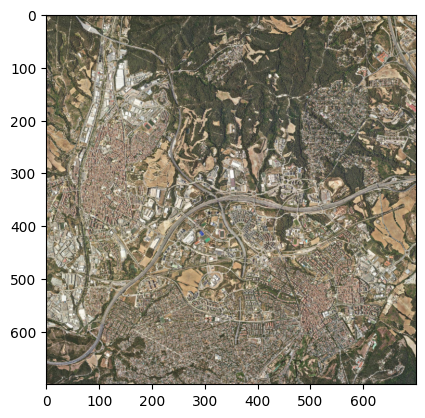

In [58]:
#  make request from url
response = requests.get(unparsed_url)
img = Image.open(BytesIO(response.content))
plt.imshow(img)
plt.show()

In [59]:
response = requests.get("https://descarregues.icgc.cat/generateZip/d90e37e6dbc9da6f8dd2bee35bba2f70/279110&/7/shp")
web  = BeautifulSoup(response.content)

In [83]:
url_zip = web.p.a["href"]
r = requests.get(url_zip, stream=True)
zipfile.ZipFile(BytesIO(r.content)).extractall()